# Quantum Informatics
## Lab 3

In [ ]:
from math import pi, sqrt, acos as arc_cos
import time

from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import array_to_latex, plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as IBMSampler

### Task 1 (1 point)

Zaimplementować obwody z [zadań obliczeniowych](./introduction/introduction-instructions-lab3.pdf) używając biblioteki qiskit. Przetestować (można używając narzędzi lokalnych).

#### Task 1.1

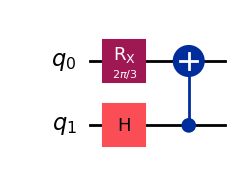

In [2]:
qc = QuantumCircuit(2)

qc.rx(theta=2 / 3 * pi, qubit=0)
qc.h(qubit=1)
qc.cx(control_qubit=1, target_qubit=0)

qc.draw("mpl")

In [3]:
state = Statevector.from_instruction(qc)

state.draw("latex")

<IPython.core.display.Latex object>

In [4]:
array_to_latex(state)

<IPython.core.display.Latex object>

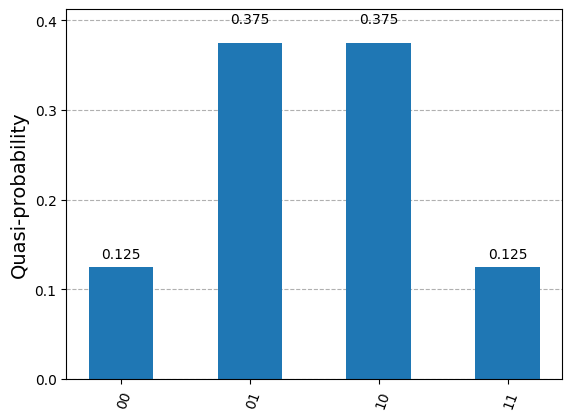

In [5]:
ideal_distribution = state.probabilities_dict()

plot_histogram(ideal_distribution)

#### Task 1.2

Zadanie znaleźć jednoqbitowe bramki (t.j. macierze unitarne 2 × 2 działajace na poszczególne qbity) potrzebne do wyprodukowania stanu: 

$|\psi⟩ = \frac{1}{\sqrt{3}} |00⟩ + \frac{1}{\sqrt{3}} |01⟩ + \frac{1}{\sqrt{3}} |10⟩$

zakładając, że:
- startujemy ze stanu $|00⟩$
- na końcu, po znalezionych przez nas bramkach, zostanie użyta bramka `Ctrl-H`.

hint: Bramkę `Ctrl-H` można zrealizować za pomocą https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#ch

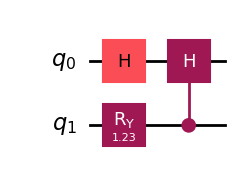

In [6]:
qc = QuantumCircuit(2)

qc.h(qubit=0)
qc.ry(theta=2 * arc_cos(sqrt(2 / 3)), qubit=1)

qc.ch(control_qubit=1, target_qubit=0)

qc.draw("mpl")

In [7]:
state = Statevector.from_instruction(qc)

state.draw("latex")

<IPython.core.display.Latex object>

In [8]:
array_to_latex(state)

<IPython.core.display.Latex object>

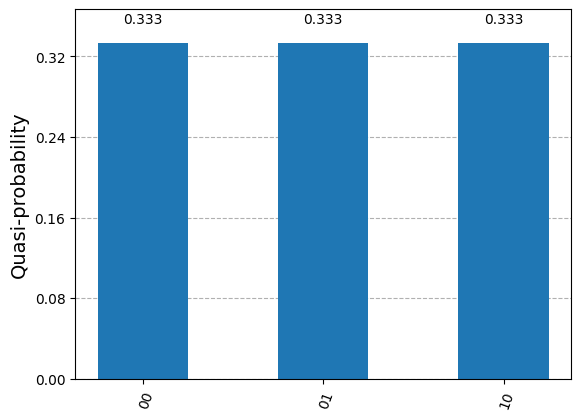

In [9]:
ideal_distribution = state.probabilities_dict()

plot_histogram(ideal_distribution)

### Task 2 (1pkt)

Za pomocą wybranego  przez siebie przykładowego  minimum 3-qbitowego i innego niż w podanym notebooku obwodu kwantowego należy  zademonstrować  różnice pomiędzy:
1. dokładnymi, wyliczonymi prawdopodobieństwami 
2. histogramem otrzymanym przez próbkowanie zgodnie z prawdopodobieństwami otrzymanymi z wybranego symulatora 
3. histogramem z prawdziwego urządzenia kwantowego

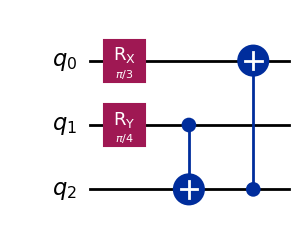

In [25]:
qc = QuantumCircuit(3)

qc.rx(theta=pi / 3, qubit=0)
qc.ry(theta=pi / 4, qubit=1)

qc.cx(control_qubit=1, target_qubit=2)
qc.cx(control_qubit=2, target_qubit=0)

qc.draw("mpl")

#### 1. Dokładne, wyliczone prawdopodobieństwa

In [26]:
state = Statevector.from_instruction(qc)

state.draw("latex")

<IPython.core.display.Latex object>

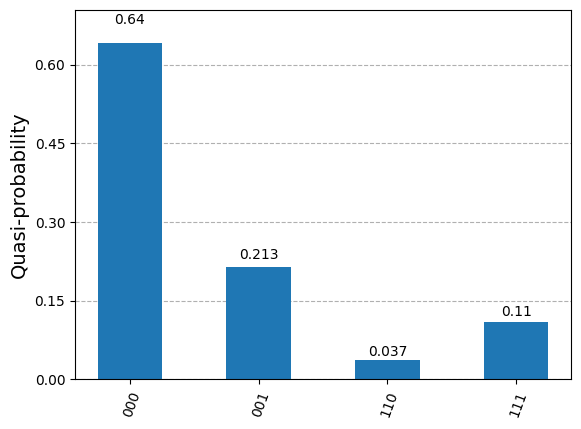

In [12]:
ideal_distribution = state.probabilities_dict()

plot_histogram(ideal_distribution)

#### 2. Próbkowanie zgodne z prawdopodobieństwami otrzymanymi z symulatora

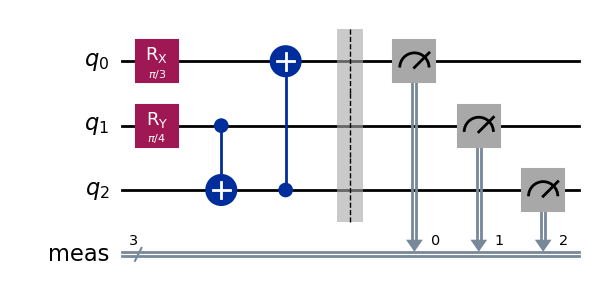

In [27]:
qc.measure_all()
qc.draw("mpl")

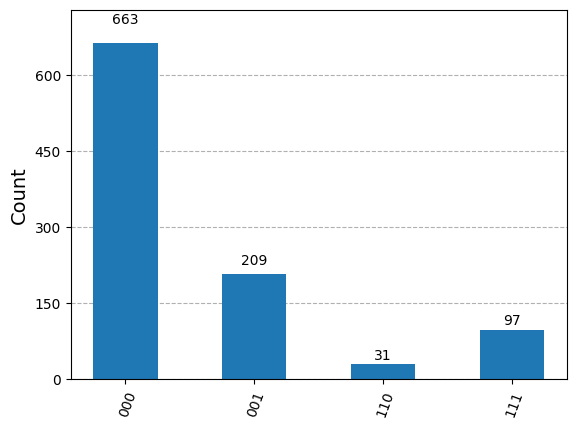

In [14]:
sampler = Sampler()

job = sampler.run([qc], shots=1000)
job_result = job.result()

pub_result = job.result()[0]
counts = pub_result.data.meas.get_counts()

plot_histogram(counts)

#### 3. Prawdziwe urządzenie kwantowe

In [15]:
def log(message: str) -> None:
    current_time = time.strftime("%H:%M:%S")
    print(f"{current_time} >>> {message}")


# QiskitRuntimeService.save_account(token="<your-token>", channel="ibm_quantum")

service = QiskitRuntimeService()

log("Runtime service initialized")

ibm_backend = service.least_busy(simulator=False, operational=True)
log(f"Selected least-busy device: {ibm_backend.name}")

23:01:59 >>> Runtime service initialized
23:02:09 >>> Selected least-busy device: ibm_kyiv


In [ ]:
pm = generate_preset_pass_manager(backend=ibm_backend)
isa_circuit = pm.run(qc)

sampler = IBMSampler(mode=ibm_backend)

job = sampler.run([(isa_circuit)])

log(f"Job ID: {job.job_id()}")

current_status = None
while True:
    new_status = job.status()
    if new_status != current_status:
        log(f"Job Status: {new_status}")

    if new_status == "DONE" or new_status == "ERROR" or new_status == "CANCELLED":
        break

    current_status = new_status
    time.sleep(0.5)

23:02:15 >>> Job ID: czm6vsqp3xeg008h9ms0
23:02:16 >>> Job Status: QUEUED
23:02:17 >>> Job Status: RUNNING
23:02:23 >>> Job Status: DONE


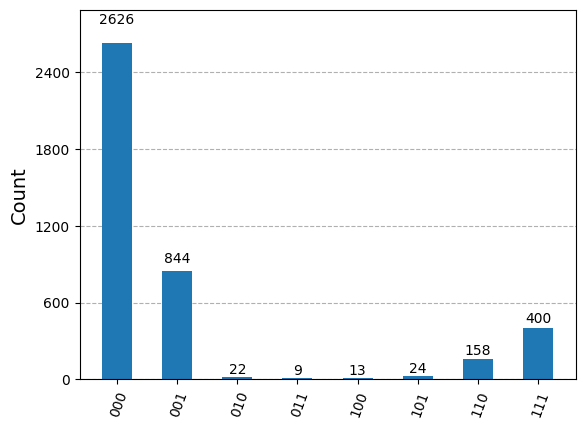

In [17]:
result = job.result()
pub_result = result[0]
ibmcounts = pub_result.data.meas.get_counts()

plot_histogram(ibmcounts)

#### Porównanie

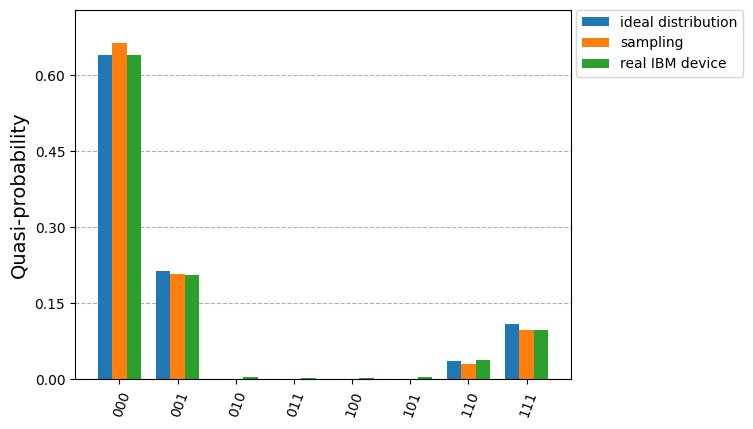

In [21]:
binary_prob = [ideal_distribution, counts, ibmcounts]

plot_histogram(
    binary_prob,
    bar_labels=False,
    legend=[
        "ideal distribution",
        "sampling",
        "real IBM device",
    ],
)

### Task 3 (1 point)

Używając  minimum 3-qbitowego obwodu innego niż w podanym notebooku należy zademonstrować różnice  pomiędzy:
1. obwodem użytkownika
2. obwodem otrzymanym z transpilera dla wybranego urządzenia kwantowego 

#### 1. Obwód użytkownika

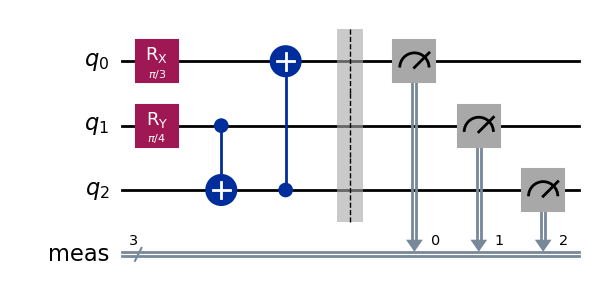

In [29]:
qc.draw("mpl")

#### 2. Obwód z transpilera urządzenia kwantowego

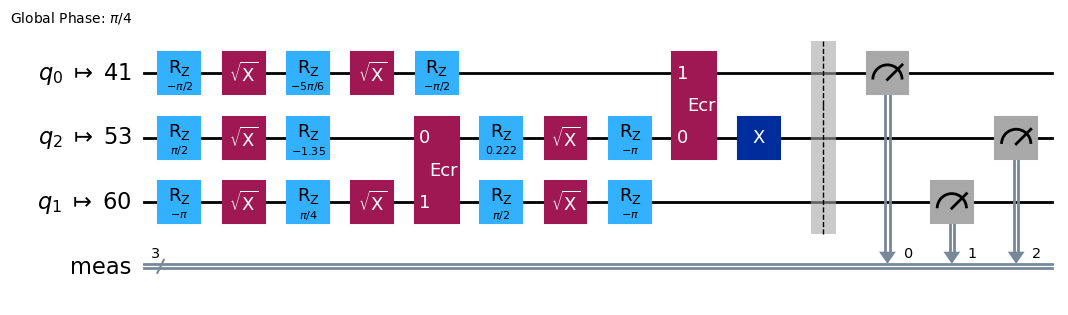

In [32]:
isa_circuit.draw("mpl", idle_wires=False)